In [1]:
import numpy as np;
from visualize import plot_2, plot_3, plot_3d, plot_6;
from load_dataset import load_grimace;
from conduct_svm import svm;
from conduct_csc import nn_csc, csc, par_csc, par_nn_csc;
from pickless import output;
from pooling import forward;
from sporco import plot, util;
from sporco.admm import cbpdn
from conduct_svm import *;

In [2]:
def make_option():
    opt = {};
    # 画像のサイズ
    opt["img_size"] = [180, 200];
    # 訓練画像の枚数
    opt['train_amount'] = 10;
    # テスト画像の枚数
    opt['test_amount'] = 10;
    # フィルタのサイズ
    opt['d_size'] = [(8, 8, 3, 6), (8, 8, 6, 16), (8, 8, 16, 8)];
    # スパースの尺度
    opt['lmbda'] = [0.2, 0.2, 0.2];
    # 繰り返し回数
    opt['Iter'] = [400, 400, 400];
    # NMFによる錐制約部分空間法における基底の数
    opt['d_num'] = 16;
    # PCAによる包括凸錐による部分空間法における累積寄与率のリスト・パラメータ
    opt["ratios"] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9];
    opt["params"] = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5];
    return opt;

In [3]:
opt = make_option();
train_img, train_label, test_img, test_label = load_grimace(opt["img_size"], opt["test_amount"]);
train_img , test_img = np.float32(train_img), np.float32(test_img);

In [5]:
npd = 16
fltlmbd = 5
sl, sh = util.tikhonov_filter(train_img, fltlmbd, npd)
t_sl, t_sh = util.tikhonov_filter(test_img, fltlmbd, npd)

### 学習用データセットで畳み込み辞書学習
第１層目:フォワードパスの計算中...
Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------
   0  1.94e+08  1.92e+08  8.05e+06  2.60e-07  7.16e-01  9.78e-01  1.05e+01  8.17e-01  1.73e-01  1.00e+01
   1  7.13e+07  6.83e+07  1.49e+07  3.44e-07  2.94e-01  1.74e+00  1.05e+01  7.72e-01  6.36e-02  1.00e+01
   2  3.49e+07  3.04e+07  2.22e+07  3.82e-07  1.50e-01  2.10e+00  1.05e+01  7.71e-01  2.89e-02  1.00e+01
   3  2.35e+07  1.86e+07  2.45e+07  2.51e-07  6.95e-02  1.66e+00  1.05e+01  6.84e-01  7.09e-03  1.00e+01
   4  1.88e+07  1.35e+07  2.61e+07  1.73e-07  4.41e-02  1.79e+00  1.05e+01  6.61e-01  6.35e-03  1.00e+01
   5  1.70e+07  1.16e+07  2.71e+07  1.56e-07  3.00e-02  1.31e+00  1.05e+01  5.68e-01  2.57e-03  1.00e+01
   6  1.57e+07  1.01e+07  2.80e+07  3.12e-07  2.44e-02  1.57e+00  1.05e+01  5.45e-01  2.61e-03  1.00e+01
   7  1.48e+

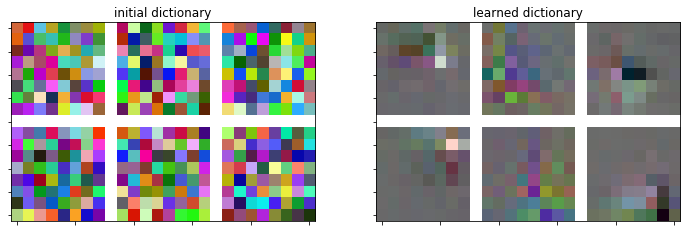

In [6]:
# 学習用データセットで辞書学習
print("### 学習用データセットで畳み込み辞書学習");

print("第１層目:フォワードパスの計算中...");
d0, D0, coef0_ = nn_csc(input_ = sh, d_size = opt['d_size'][0], lmbda = opt['lmbda'][0], Iter = opt['Iter'][0], visualize = True);
print("第１層目:プーリング中...");
coef0 = forward(coef0_.squeeze().transpose(2, 3, 0, 1), 2, 2, 2).transpose(1, 2, 3, 0);

In [7]:
print("第２層目:フォワードパスの計算中...");
d1, D1, coef1_ = nn_csc(input_ = coef0, d_size = opt['d_size'][1], lmbda = opt['lmbda'][1], Iter = opt['Iter'][1], visualize = False);
print("第２層目:プーリング中...");
coef1 = forward(coef1_.squeeze().transpose(2, 3, 0, 1), 2, 2, 2).transpose(1, 2, 3, 0);

第２層目:フォワードパスの計算中...
Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------
   0  4.48e+07  4.42e+07  2.96e+06  1.35e-15  7.17e-01  9.60e-01  1.05e+01  7.53e-01  1.75e-01  1.00e+01
   1  3.16e+07  3.05e+07  5.33e+06  1.84e-15  3.09e-01  1.98e+00  1.05e+01  6.26e-01  1.10e-01  1.00e+01
   2  2.22e+07  2.07e+07  7.50e+06  1.72e-15  1.54e-01  1.89e+00  1.05e+01  6.56e-01  4.84e-02  1.00e+01
   3  2.00e+07  1.83e+07  8.58e+06  1.81e-15  8.40e-02  1.62e+00  1.05e+01  5.14e-01  1.76e-02  1.00e+01
   4  1.86e+07  1.67e+07  9.40e+06  1.62e-15  5.62e-02  1.40e+00  1.05e+01  5.09e-01  1.31e-02  1.00e+01
   5  1.79e+07  1.59e+07  1.01e+07  1.62e-15  4.13e-02  1.33e+00  1.05e+01  3.94e-01  8.34e-03  1.00e+01
   6  1.74e+07  1.53e+07  1.06e+07  1.44e-15  3.20e-02  1.21e+00  1.05e+01  3.76e-01  7.23e-03  1.00e+01
   7  1.70e+07  1.48e+07  1.11e+07 

In [8]:
print("第3層目:フォワードパスの計算中...");
d2, D2, coef2_ = nn_csc(input_ = coef1, d_size = opt['d_size'][2], lmbda = opt['lmbda'][2], Iter = opt['Iter'][2], visualize = False);
print("第3層目:プーリング中...");
coef2 = forward(coef2_.squeeze().transpose(2, 3, 0, 1), 2, 2, 2).transpose(1, 2, 3, 0);

第3層目:フォワードパスの計算中...
Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------
   0  1.52e+07  1.51e+07  3.20e+05  1.47e-15  7.45e-01  8.93e-01  1.05e+01  9.45e-01  7.43e-02  1.00e+01
   1  1.30e+07  1.29e+07  6.50e+05  2.58e-15  3.49e-01  2.06e+00  1.05e+01  9.37e-01  4.61e-02  1.00e+01
   2  1.10e+07  1.08e+07  1.05e+06  2.15e-15  1.90e-01  2.53e+00  1.05e+01  9.52e-01  1.65e-02  1.00e+01
   3  1.02e+07  9.99e+06  1.26e+06  8.47e-16  9.83e-02  1.90e+00  1.05e+01  8.98e-01  6.46e-03  1.00e+01
   4  9.78e+06  9.49e+06  1.45e+06  2.21e-15  6.67e-02  1.71e+00  1.05e+01  9.10e-01  5.34e-03  1.00e+01
   5  9.50e+06  9.17e+06  1.62e+06  1.03e-15  5.09e-02  1.56e+00  1.05e+01  8.36e-01  3.28e-03  1.00e+01
   6  9.26e+06  8.91e+06  1.77e+06  2.30e-15  4.03e-02  1.46e+00  1.05e+01  8.43e-01  3.12e-03  1.00e+01
   7  9.09e+06  8.70e+06  1.91e+06 

In [9]:
print(coef2.shape);

(22, 25, 8, 180)


In [10]:
train_coef = coef2.transpose(3, 0, 1, 2).reshape(opt["train_amount"]*18, -1);

In [11]:
 coef3.shape

NameError: name 'coef3' is not defined

In [12]:
train_coef.shape

(180, 4400)

In [13]:
# テスト用データセットの係数算出
print("### テスト用データセットの係数算出 ###");

test_opt0 = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': opt["Iter"][0], 'RelStopTol': 5e-3, 'AuxVarObj': False, 'NonNegCoef':True});
b0 = cbpdn.ConvBPDN(D0.squeeze(), t_sh, opt["lmbda"][0], test_opt0);

print("第１層目:フォワードパスの計算中...");
test_coef0 = b0.solve();
print("第１層目:プーリング中...");
test_coef0 = forward(test_coef0.squeeze().transpose(2,3,0,1), 2, 2, 2).transpose(1,2,3,0);


test_opt1 = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': opt["Iter"][1], 'RelStopTol': 5e-3, 'AuxVarObj': False, 'NonNegCoef':True});
test_coef0 = np.expand_dims(test_coef0, -1);
b1 = cbpdn.ConvBPDN(D1.squeeze(), test_coef0, opt["lmbda"][1], test_opt1);
print("第２層目:フォワードパスの計算中...");
test_coef1 = b1.solve();
print("第２層目:プーリング中...");
test_coef1 = forward(test_coef1.squeeze().transpose(2,3,0,1), 2, 2, 2).transpose(1,2,3,0);

test_opt2 = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': opt["Iter"][2], 'RelStopTol': 5e-3, 'AuxVarObj': False, 'NonNegCoef':True});
test_coef1 = np.expand_dims(test_coef1, -1);
b2 = cbpdn.ConvBPDN(D2.squeeze(), test_coef1, opt["lmbda"][2], test_opt2);
print("第3層目:フォワードパスの計算中...");
test_coef2 = b2.solve();
print("第3層目:プーリング中...");
test_coef2 = forward(test_coef2.squeeze().transpose(2,3,0,1), 2, 2, 2).transpose(1,2,3,0);


test_feature = test_coef2.transpose(3, 0, 1, 2).reshape(opt["test_amount"]*18, -1);
print("test_feature:", test_feature.shape);

### テスト用データセットの係数算出 ###
第１層目:フォワードパスの計算中...
Itn   Fnc       DFid      Regℓ1     r         s         ρ       
----------------------------------------------------------------
   0  1.08e+08  1.06e+08  9.67e+06  7.03e-01  1.01e+00  1.10e+01
   1  1.09e+08  1.05e+08  1.67e+07  3.12e-01  4.46e+00  1.10e+01
   2  2.38e+07  1.77e+07  3.03e+07  2.57e-01  1.89e+00  1.58e+00
   3  2.07e+07  6.61e+06  7.06e+07  4.06e-01  2.70e+00  3.16e-01
   4  1.87e+07  8.57e+05  8.93e+07  4.23e-01  8.63e-01  6.64e-02
   5  1.83e+07  5.15e+05  8.87e+07  6.74e-01  4.29e-01  2.52e-02
   6  1.71e+07  5.18e+05  8.31e+07  7.81e-01  1.89e-01  1.72e-02
   7  1.36e+07  6.29e+05  6.49e+07  6.16e-01  1.83e-01  1.89e-02
   8  1.34e+07  6.54e+05  6.35e+07  4.41e-01  1.35e-01  1.89e-02
   9  1.23e+07  6.33e+05  5.86e+07  3.80e-01  1.24e-01  1.89e-02
  10  1.08e+07  6.42e+05  5.06e+07  3.72e-01  1.11e-01  1.89e-02
  11  9.87e+06  6.81e+05  4.59e+07  3.25e-01  8.97e-02  1.89e-02
  12  9.65e+06  6.99e+05  4.48e+07  2.46e-01  

In [14]:
# SVMによる分類
clf = train_svm(train_coef, train_label);
test_precision = test_svm(clf, test_feature, test_label);

Train precision:  1.0
Test precision:  0.7055555555555556


In [22]:
# 錐を作るための関数郡
from sklearn.metrics.pairwise import cosine_similarity;
from sklearn.decomposition import NMF
def create_cone_NMF(feature, num):
    nmf = NMF(n_components=num);
    W = nmf.fit_transform(feature);
    H = nmf.components_;
    return nmf, H, W;

def restore_from_cone_NMF(feature, nmf):
    restore = nmf.inverse_transform(nmf.transform(feature));
    return restore;

def NMF_Classifier(train_feature, train_label, test_feature, test_label, from_, to_, class_num):
    accuracy = []
    for h in range(from_, to_+1):
        NMFs = [];
        Hs = [];
        Ws = [];
        for i in range(class_num):
            #print(str(i)+"番目のクラスの錐を作成中...");
            nmf, H, W = create_cone_NMF(train_feature[train_label == i], h);
            NMFs.append(nmf);
            Hs.append(H);
            Ws.append(W);
        restores = [];
        for i in range(class_num):
            #print(str(i)+"番目のクラスの錐で入力を再現中...")
            temp = restore_from_cone_NMF(test_feature, NMFs[i]);
            restores.append(temp);
        CosArray = [];
        for i in range(class_num):
            cos_array = cosine_similarity(test_feature, restores[i]);
            CosArray.append(np.diag(cos_array));            
        CosArray = np.array(CosArray);
        predict_label = np.argmax(CosArray, axis = 0);
        precision = sum(predict_label == test_label)/test_label.shape[0];
        accuracy.append(precision);
        print("d_num="+str(h)+": Test precision: ", precision);
    fig = plot.figure();
    ax = fig.add_subplot(111);
    ax.set_xlabel("# of basis");
    ax.set_ylabel("Accuracy");
    ax.set_ylim(0.8, 1.0);
    ax.plot(accuracy);
    ax.set_title("Cone restricted subspace method by NMF");
    fig.savefig("result/nmf_grimace.png")

d_num=1: Test precision:  0.9722222222222222
d_num=2: Test precision:  0.9444444444444444
d_num=3: Test precision:  0.9444444444444444
d_num=4: Test precision:  0.9722222222222222
d_num=5: Test precision:  0.9722222222222222
d_num=6: Test precision:  0.9722222222222222
d_num=7: Test precision:  0.9722222222222222
d_num=8: Test precision:  0.9722222222222222
d_num=9: Test precision:  0.9722222222222222
d_num=10: Test precision:  0.9722222222222222
d_num=11: Test precision:  0.9666666666666667
d_num=12: Test precision:  0.9666666666666667
d_num=13: Test precision:  0.9722222222222222
d_num=14: Test precision:  0.9666666666666667
d_num=15: Test precision:  0.9555555555555556
d_num=16: Test precision:  0.9611111111111111


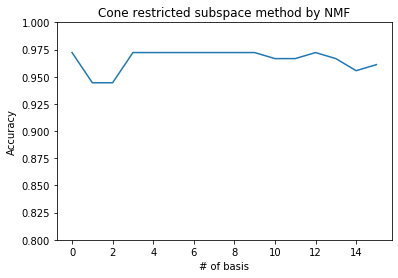

In [23]:
NMF_Classifier(train_coef, train_label, test_feature, test_label, 1, 16, 18);

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from scipy.optimize import nnls;

def create_cone_PCA(feature, param, ratio):
    feature = normalize(feature);
    pca = PCA(n_components=ratio);
    pca.fit(feature);
    variance = pca.explained_variance_;
    mean = pca.mean_;
    basis = pca.components_;
    cone_basis = [];
    cnt = 0;
    for i in variance:
        cone_basis.append(mean+param*np.sqrt(i)*basis[cnt]);
        cone_basis.append(mean-param*np.sqrt(i)*basis[cnt]);
        cnt=cnt+1;
    cone_basis = np.array(cone_basis);
    return cone_basis;

def restore_from_cone_PCA(cone_basis, feature):
    feature = list(feature);
    restore = [];
    for i in feature:
        x = np.array(nnls(cone_basis.T, i)[0]);
        restore.append(cone_basis.T.dot(x));
    restore = np.array(restore);
    return restore;

In [18]:
from matplotlib import pyplot as plt
def PCA_Classifier(train_feature, train_label, test_feature, test_label, params, ratios, class_num):
    fig = plot.figure();
    ax = fig.add_subplot(111);
    cmap = plt.get_cmap("tab10");
    ax.set_title("Cone restricted subspace method by Comprehensive cone");
    ax.set_xlabel("ratios");
    ax.set_ylabel("Accuracy");
    ax.set_ylim(0.8, 1.0);
    cnt=0;
    for param in params:
        accuracy = [];
        print("the parameter of scaling : "+str(param))
        for ratio in ratios:
            Cones = [];

            for i in range(class_num):
                #print(str(i)+"番目のクラスの錐を作成中...");
                cone = create_cone_PCA(train_feature[train_label == i], param, ratio);
                Cones.append(cone);
            restores = [];
            for i in range(class_num):
                #print(str(i)+"番目のクラスの錐で入力を再現中...")
                temp = restore_from_cone_PCA(Cones[i], test_feature);
                restores.append(temp);
            CosArray = [];
            for i in range(class_num):
                cos_array = cosine_similarity(test_feature, restores[i]);
                CosArray.append(np.diag(cos_array));

            CosArray = np.array(CosArray);
            predict_label = np.argmax(CosArray, axis = 0);
            precision = sum(predict_label == test_label)/test_label.shape[0];
            print("ratio="+str(ratio)+": Test precision: ", precision);
            accuracy.append(precision);
        ax.plot(accuracy, label = "k="+str(param), color = cmap(cnt));
        cnt=cnt+1;
    ax.legend();
    fig.savefig("result/Comprehensive_grimace.png");

the parameter of scaling : 0.5
ratio=0.1: Test precision:  0.9444444444444444
ratio=0.2: Test precision:  0.9444444444444444
ratio=0.3: Test precision:  0.9555555555555556
ratio=0.4: Test precision:  0.9555555555555556
ratio=0.5: Test precision:  0.9555555555555556
ratio=0.6: Test precision:  0.9611111111111111
ratio=0.7: Test precision:  0.9611111111111111
ratio=0.8: Test precision:  0.9611111111111111
ratio=0.9: Test precision:  0.9611111111111111
the parameter of scaling : 1.0
ratio=0.1: Test precision:  0.9444444444444444
ratio=0.2: Test precision:  0.9444444444444444
ratio=0.3: Test precision:  0.9444444444444444
ratio=0.4: Test precision:  0.9444444444444444
ratio=0.5: Test precision:  0.9444444444444444
ratio=0.6: Test precision:  0.9722222222222222
ratio=0.7: Test precision:  0.9722222222222222
ratio=0.8: Test precision:  0.9722222222222222
ratio=0.9: Test precision:  0.9722222222222222
the parameter of scaling : 1.5
ratio=0.1: Test precision:  0.9444444444444444
ratio=0.2: Tes

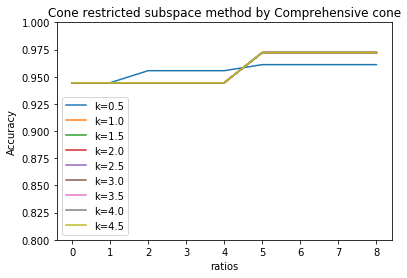

In [19]:
PCA_Classifier(train_coef, train_label, test_feature, test_label, opt["params"], opt["ratios"], 18);